# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP

**DSI-41 Group 2**: Muhammad Faaiz Khan, Lionel Foo, Gabriel Tan

## **Project title**: Generative AI and Art - understanding and predicting chatter from online communities

## Part 3 EDA

## 01. Imports

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')

from textblob import TextBlob

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

[nltk_data] Downloading package wordnet to /Users/lionel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lionel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 02. Load and Check Data

In [2]:
# Load data:
reddit = pd.read_csv('./output/reddit_cleaned.csv')
# Drop irrelevant columns
reddit.drop(columns = ['Unnamed: 0'], inplace = True)

# Check data:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7472 entries, 0 to 7471
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subr-def_ai   7472 non-null   int64 
 1   is_op         7472 non-null   int64 
 2   author        7472 non-null   object
 3   post_id       7472 non-null   object
 4   body          7442 non-null   object
 5   upvotes       7472 non-null   int64 
 6   num_comments  7472 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 408.8+ KB


### 02.01 Based on our inspection of the cleaned reddit csv file we have noted the following:
- certain rows have no text after the data cleaning in Part 2
- To drop these rows

In [3]:
# Replace NaN values with an empty string for consistency
reddit['body'] = reddit['body'].fillna('')

# Check if any rows in 'body' consist of only '0', '', or only newline character
rows_with_zeros_or_newline = reddit[(reddit['body'].isin(['0', '', '\n', '\n\n', '\n\n\n', '\n\n\n\n']))]

# Display the rows that meet the condition
print(rows_with_zeros_or_newline.shape)
rows_with_zeros_or_newline

(32, 7)


,subr-def_ai,is_op,author,post_id,body,upvotes,num_comments
117,1,0,Recursivefunktion,jye301l,,1,0
302,1,0,starstruckmon,j2jezlp,,28,1
607,1,0,transwarcriminal,khj2wjp,,1,1
617,1,0,CanonOverseer,j1s7fit,,3,0
1439,1,0,SIP-BOSS,j4ecudm,,7,0
1983,1,0,Herr_Drosselmeyer,kdy8a6q,,5,0
2339,1,0,AdPrevious2308,jv6v3f3,,2,0
2586,1,0,Fu_Man_Chu,k7rej0t,,6,0
2600,1,0,imanul,j2lu13f,,5,0
2875,1,0,Another_available,kg01ljo,,11,0


In [4]:
# Drop the rows with no actual text and reset the index
reddit = reddit.drop(rows_with_zeros_or_newline.index).reset_index(drop=True)
# Display the updated DataFrame info
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7440 entries, 0 to 7439
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subr-def_ai   7440 non-null   int64 
 1   is_op         7440 non-null   int64 
 2   author        7440 non-null   object
 3   post_id       7440 non-null   object
 4   body          7440 non-null   object
 5   upvotes       7440 non-null   int64 
 6   num_comments  7440 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 407.0+ KB


## 03. EDA on 'body'

### 03.01 EDA on posts length 
- looking at the lengths and word count in each subreddit 'body'.
- Create a new column called 'body_length' that contains the length of each body.
- Create a new column called `body_word_count` that contains the number of words in each body.

In [5]:
# Create a new column 'body_length' calculating the length of each entry in the 'body' column using the apply function and len
reddit['body_length'] = reddit['body'].apply(len)

reddit.head()

,subr-def_ai,is_op,author,post_id,body,upvotes,num_comments,body_length
0,1,1,deleted,101n5dv,"[TW: DEATH THREAT] And they say that ""AI bros"" are the ones harassing the artists?",498,9,82
1,1,0,Zinthaniel,j2plqsw,"there's no rule in this sub requiring you to hide the tweet handle. So its kind of idiotic to do so, especially when the tweet is glorifying killing people who use AI.",30,1,167
2,1,0,deleted,j2oryjg,"""Corpos telling modern artists to die""\nIT'S FREE AND OPEN SOURCE",56,2,64
3,1,0,chillaxinbball,j2rbhzy,Unfortunately there are a few idiots on Twitter that are being rude which is giving the antiai crowd a huge confirmation bias boner. The Anti ai crowd has a hard time separating individuals from the group and seeing that the *majority* of the hateful comments comes from them.,12,0,276
4,1,0,Trippy-Worlds,j2oyyyb,Why is the username crossed out? They need to be reported on Twitter and probably to the FBI. \n\nWould really like to see who all those likes are as well. Please tell us the Twitter ID. Suggesting violence is not permissible!,23,1,224


In [6]:
reddit['status_word_count'] = reddit['body'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))))
reddit.head()

,subr-def_ai,is_op,author,post_id,body,upvotes,num_comments,body_length,status_word_count
0,1,1,deleted,101n5dv,"[TW: DEATH THREAT] And they say that ""AI bros"" are the ones harassing the artists?",498,9,82,15
1,1,0,Zinthaniel,j2plqsw,"there's no rule in this sub requiring you to hide the tweet handle. So its kind of idiotic to do so, especially when the tweet is glorifying killing people who use AI.",30,1,167,33
2,1,0,deleted,j2oryjg,"""Corpos telling modern artists to die""\nIT'S FREE AND OPEN SOURCE",56,2,64,12
3,1,0,chillaxinbball,j2rbhzy,Unfortunately there are a few idiots on Twitter that are being rude which is giving the antiai crowd a huge confirmation bias boner. The Anti ai crowd has a hard time separating individuals from the group and seeing that the *majority* of the hateful comments comes from them.,12,0,276,48
4,1,0,Trippy-Worlds,j2oyyyb,Why is the username crossed out? They need to be reported on Twitter and probably to the FBI. \n\nWould really like to see who all those likes are as well. Please tell us the Twitter ID. Suggesting violence is not permissible!,23,1,224,41


In [7]:
# Define a function to get the 10 longest and 10 shortest posts for each subreddit
def get_longest_shortest_posts(df, subreddit):
    # Filter the DataFrame for the specific subreddit
    subreddit_df = df[df['subr-def_ai'] == subreddit]
    
    # Get the 10 longest and 10 shortest posts based on the 'status_word_count'
    longest_posts = subreddit_df.nlargest(10, 'status_word_count')
    shortest_posts = subreddit_df.nsmallest(10, 'status_word_count')
    
    return longest_posts, shortest_posts

# Get the 10 longest and 10 shortest posts for subreddit DefendingAIArt (subr-def_ai = 1)
longest_posts_defendingai, shortest_posts_defendingai = get_longest_shortest_posts(reddit, 1)

# Get the 10 longest and 10 shortest posts for subreddit ArtistHate (subr-def_ai = 0)
longest_posts_artisthate, shortest_posts_artisthate = get_longest_shortest_posts(reddit, 0)

# Display the results
print("Top 10 Longest Posts in DefendingAIArt:")
print(longest_posts_defendingai[['body', 'status_word_count']])
print("\nTop 10 Shortest Posts in DefendingAIArt:")
print(shortest_posts_defendingai[['body', 'status_word_count']])

print("\nTop 10 Longest Posts in ArtistHate:")
print(longest_posts_artisthate[['body', 'status_word_count']])
print("\nTop 10 Shortest Posts in ArtistHate:")
print(shortest_posts_artisthate[['body', 'status_word_count']])

Top 10 Longest Posts in DefendingAIArt:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Distribution of Post Lengths Analysis

To visually analyze and compare the distribution of post lengths in both subreddits: "DefendingAIArt" and "ArtistHate." The analysis is conducted based on both word counts and body lengths of posts.

/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

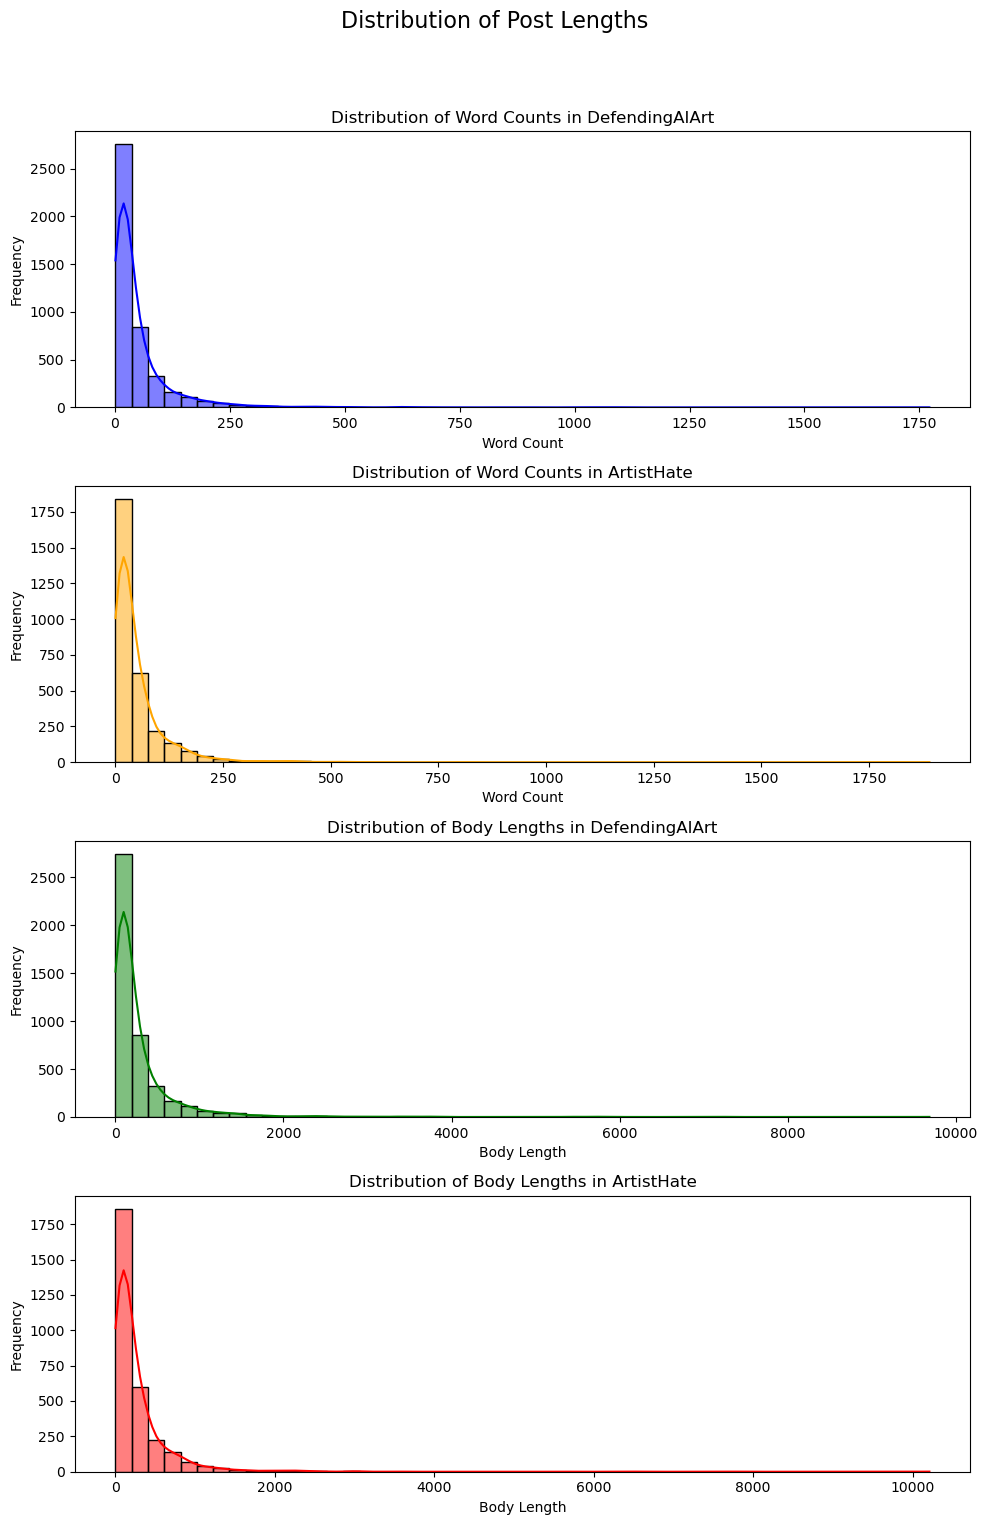

In [8]:
# Set up the figure and axes
fig, axes = plt.subplots(4, 1, figsize=(10, 16))
fig.suptitle("Distribution of Post Lengths", fontsize=16)

# Distribution of word counts for subreddit DefendingAIArt (subr-def_ai = 1)
sns.histplot(reddit[reddit['subr-def_ai'] == 1]['status_word_count'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Word Counts in DefendingAIArt")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

# Distribution of word counts for subreddit ArtistHate (subr-def_ai = 0)
sns.histplot(reddit[reddit['subr-def_ai'] == 0]['status_word_count'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Distribution of Word Counts in ArtistHate")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")

# Distribution of body lengths for subreddit DefendingAIArt (subr-def_ai = 1)
sns.histplot(reddit[reddit['subr-def_ai'] == 1]['body_length'], bins=50, kde=True, ax=axes[2], color='green')
axes[2].set_title("Distribution of Body Lengths in DefendingAIArt")
axes[2].set_xlabel("Body Length")
axes[2].set_ylabel("Frequency")

# Distribution of body lengths for subreddit ArtistHate (subr-def_ai = 0)
sns.histplot(reddit[reddit['subr-def_ai'] == 0]['body_length'], bins=50, kde=True, ax=axes[3], color='red')
axes[3].set_title("Distribution of Body Lengths in ArtistHate")
axes[3].set_xlabel("Body Length")
axes[3].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lionel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


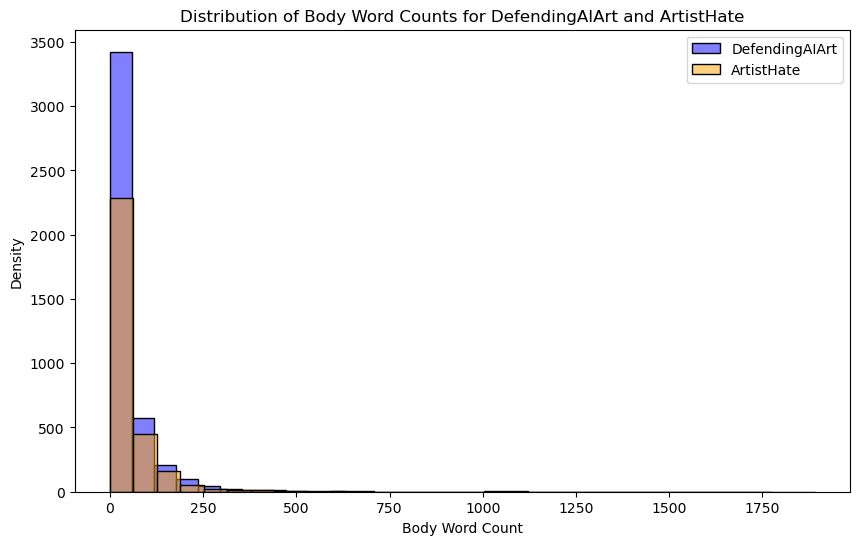

In [9]:
defending_ai_word_count = reddit[reddit['subr-def_ai'] == 1]['status_word_count']
artist_hate_word_count = reddit[reddit['subr-def_ai'] == 0]['status_word_count']

# Plot the distribution using sns.histplot
plt.figure(figsize=(10, 6))
sns.histplot(defending_ai_word_count, label='DefendingAIArt', color='blue', alpha=0.5, bins=30)
sns.histplot(artist_hate_word_count, label='ArtistHate', color='orange', alpha=0.5, bins=30)

# Add labels and title
plt.xlabel('Body Word Count')
plt.ylabel('Density')
plt.title('Distribution of Body Word Counts for DefendingAIArt and ArtistHate')
plt.legend()

# Show the plot
plt.show()

In [10]:
# This code is meant to analyze the top 1000 shortest texts from the 'DefendingAIArt' subreddit
# Filter rows for 'DefendingAIArt' and sort based on 'status_word_count'
defending_ai_shortest_text = reddit[reddit['subr-def_ai'] == 1].sort_values(by='status_word_count')

# Select the first 1000 rows
defending_ai_shortest_text = defending_ai_shortest_text.head(1000)

# Display all data rows:
pd.set_option('display.max_rows', None)

# Display the resulting DataFrame
defending_ai_shortest_text['body']

2126                                                                                    *Wawawawa!*
1416                                                                                             No
2890                                                                                         what??
1994                                                                                           lmao
815                                                                                          Thank.
344                                                                                         Exactly
345                                                                                             Yep
66                                                                                              LOL
350                                                                                           Keyed
1273                                                                                           damn


### Class Imbalance Analysis

- For our project to accurately predict the subreddit to which a particular text belongs, we have noted a noteworthy class imbalance, especially within posts containing fewer than 50 words in the DefendingAIArt subreddit. Recognizing the importance of obtaining meaningful insights from our data, we've conducted a thorough analysis and decided to address this imbalance.

- In the context of our broader goal, where DefendingAIArt is associated with pro AI art sentiments and ArtistHate with anti AI art sentiments, we understand the significance of each comment contributing substantively to our model's training and evaluation. Comments with minimal word counts are likely to provide limited information and context, potentially affecting the accuracy of our predictions.

- To enhance the quality of our predictive model, we have opted to selectively remove rows from the DefendingAIArt subreddit, focusing on those with the lowest word count. This strategic approach ensures that our model is trained on more informative and context-rich comments, fostering a better understanding of the sentiments expressed within each subreddit.

- By achieving a balanced representation between DefendingAIArt and ArtistHate, our predictive model aims to accurately discern the subtle nuances between pro and anti AI sentiments, ultimately improving its performance in distinguishing between the two subreddits.

In [11]:
# Calculate class balance
class_balance = reddit['subr-def_ai'].value_counts(normalize=True)
class_counts = reddit['subr-def_ai'].value_counts()

# Define class labels
class_labels = {1: 'DefendingAIArt', 0: 'ArtistHate'}

# Rename the indices using the class labels
class_balance.index = class_balance.index.map(class_labels)
class_counts.index = class_counts.index.map(class_labels)

# Print out the class balance with labels
print("Class Balance (Normalized):")
print(class_balance)

# Print out the actual value counts with labels
print("\nClass Balance (Actual Counts):")
print(class_counts)

Class Balance (Normalized):
subr-def_ai
DefendingAIArt    0.595161
ArtistHate        0.404839
Name: proportion, dtype: float64

Class Balance (Actual Counts):
subr-def_ai
DefendingAIArt    4428
ArtistHate        3012
Name: count, dtype: int64


In [12]:
# Desired class balance
desired_balance = 3012

# Sort the rows for 'DefendingAIArt' based on 'status_word_count'
defending_ai_sorted = reddit[reddit['subr-def_ai'] == 1].sort_values(by='status_word_count')

# Calculate the number of rows to drop
rows_to_drop = len(defending_ai_sorted) - desired_balance

# Drop the excess rows
reddit.drop(index=defending_ai_sorted.head(rows_to_drop).index, inplace=True)

# Verify the new class balance
new_class_balance = reddit['subr-def_ai'].value_counts()
print("New Class Balance (Actual Counts):")
print(new_class_balance)

New Class Balance (Actual Counts):
subr-def_ai
1    3012
0    3012
Name: count, dtype: int64


In [13]:
reddit.shape

(6024, 9)

### 03.01 Assessment of the distribution of word counts and body lengths (len(text)) of comments from the two subreddits, DefendingAIart and ArtistHate:
1. DefendingAIart:
- Word Count: The majority of comments have a word count below 250, indicating that most comments are relatively short.
- Body Length: The body length is also primarily under 2000 characters, which aligns with the shorter word counts.
2. ArtistHate:
- Word Count: Similar to DefendingAIart, the majority of comments have a word count below 250.
- Body Length: The body length distribution mirrors this, with most comments being under 2000 characters in length.


In both subreddits, the distributions are right-skewed, meaning that there are a few comments that are much longer than the majority. 

### 03.02 EDA on unique users

In [14]:
# Define the subreddit column
subreddit_column = 'subr-def_ai'

# Filter the DataFrame for DefendingAIArt
defending_ai_df = reddit[reddit[subreddit_column] == 1]

# Exclude posts made by 'deleted'
defending_ai_df = defending_ai_df[defending_ai_df['author'] != 'deleted']

# Calculate the top 20 users in DefendingAIArt
top_20_defending_ai_users = defending_ai_df['author'].value_counts().head(20)

# Number of unique users for DefendingAIArt
defending_ai_unique_users = defending_ai_df['author'].nunique()

# Calculate the total number of posts for DefendingAIArt
total_defending_ai_posts = len(defending_ai_df)

# Calculate the proportion of posts made by the top 20 users in DefendingAIArt
proportion_defending_ai_top_20 = top_20_defending_ai_users.sum() / total_defending_ai_posts

# Display the results for DefendingAIArt
print("\nDefendingAIArt:")
print(f"Number of Unique Users: {defending_ai_unique_users}")
print(f"Total Number of Posts: {total_defending_ai_posts}")
print(f"Proportion of Posts by Top 20 Users: {proportion_defending_ai_top_20:.2%}")
print(f"Top 20 Posters:\n{top_20_defending_ai_users}")

# Filter the DataFrame for ArtistHate
artist_hate_df = reddit[reddit[subreddit_column] == 0]

# Exclude posts made by 'deleted'
artist_hate_df = artist_hate_df[artist_hate_df['author'] != 'deleted']

# Calculate the top 20 users in ArtistHate
top_20_artist_hate_users = artist_hate_df['author'].value_counts().head(20)

# Number of unique users for ArtistHate
artist_hate_unique_users = artist_hate_df['author'].nunique()

# Calculate the total number of posts for ArtistHate
total_artist_hate_posts = len(artist_hate_df)

# Calculate the proportion of posts made by the top 20 users in ArtistHate
proportion_artist_hate_top_20 = top_20_artist_hate_users.sum() / total_artist_hate_posts

# Display the results for ArtistHate
print("\nArtistHate:")
print(f"Number of Unique Users: {artist_hate_unique_users}")
print(f"Total Number of Posts: {total_artist_hate_posts}")
print(f"Proportion of Posts by Top 20 Users: {proportion_artist_hate_top_20:.2%}")
print(f"Top 20 Posters:\n{top_20_artist_hate_users}")


DefendingAIArt:
Number of Unique Users: 1096
Total Number of Posts: 2919
Proportion of Posts by Top 20 Users: 15.42%
Top 20 Posters:
author
Tyler_Zoro              47
doatopus                44
Present_Dimension464    38
AShellfishLover         35
chillaxinbball          30
BusyPhilosopher15       25
mang_fatih              19
Ka_Trewq                19
EmotionalCrit           19
Trippy-Worlds           18
shimapanlover           18
intuitive-arts          17
FaceDeer                17
Concheria               17
GreenTeaBD              15
ifandbut                15
greenyashiro            15
Meadhbh_Ros             14
Rafcdk                  14
LD2WDavid               14
Name: count, dtype: int64

ArtistHate:
Number of Unique Users: 603
Total Number of Posts: 2917
Proportion of Posts by Top 20 Users: 31.95%
Top 20 Posters:
author
WonderfulWanderer777    269
Alkaia1                 136
lycheedorito             57
KoumoriChinpo            51
BlueFlower673            42
Neat-Tone-2747   

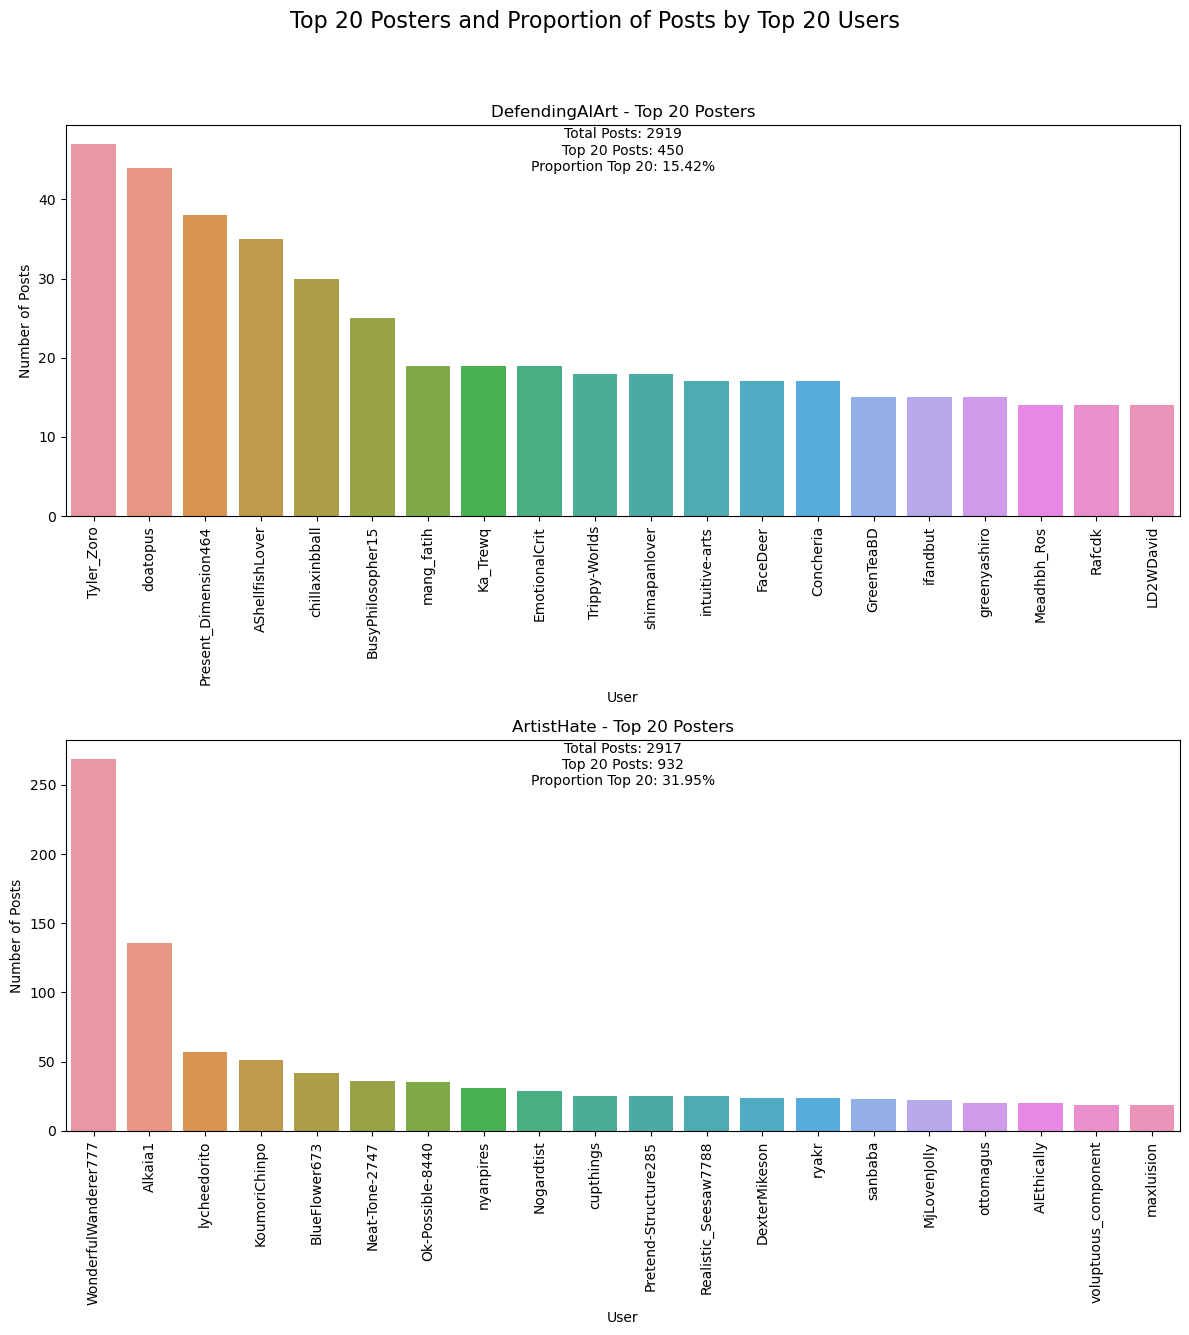

In [15]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 14))
fig.suptitle("Top 20 Posters and Proportion of Posts by Top 20 Users", fontsize=16)

# DefendingAIArt
sns.barplot(x=top_20_defending_ai_users.index, y=top_20_defending_ai_users, ax=axes[0])
axes[0].set_title("DefendingAIArt - Top 20 Posters")
axes[0].set_xlabel("User")
axes[0].set_ylabel("Number of Posts")
axes[0].tick_params(axis='x', rotation=90)  # Rotate 90 degrees

# Annotate with additional information
total_posts_defending_ai = defending_ai_df.shape[0]
total_posts_top_20_defending_ai = top_20_defending_ai_users.sum()
proportion_top_20_defending_ai = total_posts_top_20_defending_ai / total_posts_defending_ai

axes[0].annotate(f"Total Posts: {total_posts_defending_ai}\n"
                 f"Top 20 Posts: {total_posts_top_20_defending_ai}\n"
                 f"Proportion Top 20: {proportion_top_20_defending_ai:.2%}", 
                 xy=(0.5, 0.9), xytext=(0, 10), 
                 xycoords='axes fraction', textcoords='offset points', ha='center', va='center')

# ArtistHate
sns.barplot(x=top_20_artist_hate_users.index, y=top_20_artist_hate_users, ax=axes[1])
axes[1].set_title("ArtistHate - Top 20 Posters")
axes[1].set_xlabel("User")
axes[1].set_ylabel("Number of Posts")
axes[1].tick_params(axis='x', rotation=90)  # Rotate 90 degrees

# Annotate with additional information
total_posts_artist_hate = artist_hate_df.shape[0]
total_posts_top_20_artist_hate = top_20_artist_hate_users.sum()
proportion_top_20_artist_hate = total_posts_top_20_artist_hate / total_posts_artist_hate

axes[1].annotate(f"Total Posts: {total_posts_artist_hate}\n"
                 f"Top 20 Posts: {total_posts_top_20_artist_hate}\n"
                 f"Proportion Top 20: {proportion_top_20_artist_hate:.2%}", 
                 xy=(0.5, 0.9), xytext=(0, 10), 
                 xycoords='axes fraction', textcoords='offset points', ha='center', va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


### 03.02 Evaluation of Unique Users
1) Number of Unique Users:
  - DefendingAIArt has a higher number of unique users (1096) compared to ArtistHate (603), indicating a broader contributor base in DefendingAIArt.

2) Proportion of Posts by Top 20 Users:
  - ArtistHate has a significantly higher proportion of posts (31.95%) contributed by the top 20 users compared to DefendingAIArt (15.42%).

3)  (1) and (2) suggest that the nature of debate and conversations may be dominated by a select few in one subreddit over the other

4) Top 20 Posters:
  - The specific top 20 posters differ between the two subreddits, reflecting unique user engagement patterns in each community.

## 03.03 EDA on Word Counts

In [16]:
# additional stop words to remove
additional_stop_words = ['wa', 'ha', 'doe', 'did', 've', 'ca', 'll', 'gon', 'don', 'wan', 'na']

# Combine native 'english' stop words with additional stop words
all_stop_words = list(set(ENGLISH_STOP_WORDS).union(additional_stop_words))

In [17]:
# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization and get top N words
def get_top_words_lemmatized(df, n=20):
    # Tokenize and lemmatize the text
    df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))
    
    # Instantiate a CountVectorizer object
    vectorizer = CountVectorizer(stop_words=all_stop_words)
    
    # Fit and transform the count vectorizer on the lemmatized body text
    X = vectorizer.fit_transform(df['lemmatized_body'])
    
    # Convert to a dataframe and densify
    word_count_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    # Sum the word occurrences and sort by frequency
    word_counts = word_count_df.sum().sort_values(ascending=False)
    
    # Get the top N words
    top_words = word_counts.head(n)
    
    return top_words

# Define the subreddit column
subreddit_column = 'subr-def_ai'

# Filter the DataFrame for DefendingAIArt
defending_ai_df = reddit[reddit[subreddit_column] == 1]

# Filter the DataFrame for ArtistHate
artist_hate_df = reddit[reddit[subreddit_column] == 0]

# Get top 20 lemmatized words for DefendingAIArt
top_words_defending_ai_lemmatized = get_top_words_lemmatized(defending_ai_df, n=20)

# Get top 20 lemmatized words for ArtistHate
top_words_artist_hate_lemmatized = get_top_words_lemmatized(artist_hate_df, n=20)

# Display the results
print("\nTop 20 Lemmatized Words in DefendingAIArt:")
print(top_words_defending_ai_lemmatized)

print("\nTop 20 Lemmatized Words in ArtistHate:")
print(top_words_artist_hate_lemmatized)

/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2333264188.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))



Top 20 Lemmatized Words in DefendingAIArt:
ai        2678
art       1965
people    1533
artist    1332
just      1212
like      1167
make       724
work       679
think      670
thing      607
use        566
want       534
image      456
time       425
way        408
good       386
know       375
really     368
human      341
say        324
dtype: int64

Top 20 Lemmatized Words in ArtistHate:
ai        1550
people    1038
art       1007
just       896
like       886
artist     846
work       555
make       534
thing      441
think      431
image      431
want       356
time       325
use        315
way        307
human      307
know       303
really     260
good       258
model      246
dtype: int64


/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2333264188.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))


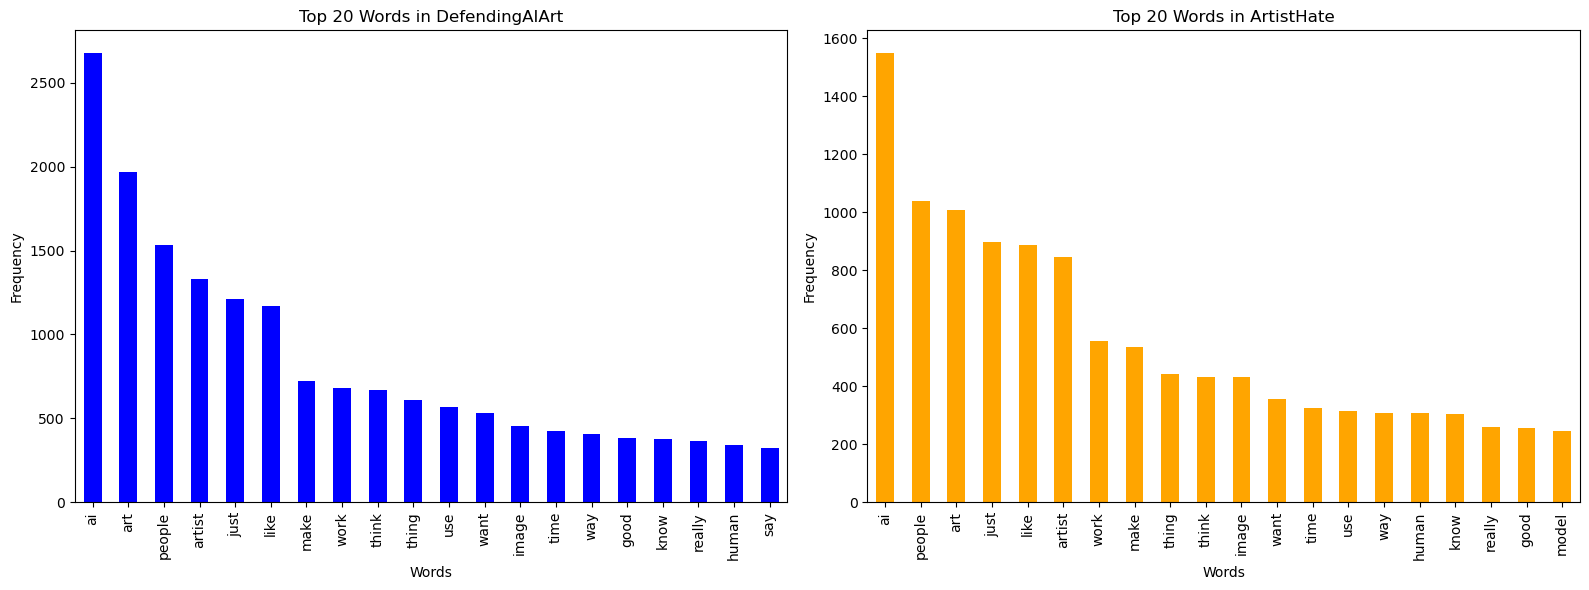

In [18]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for DefendingAIArt
top_words_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 20 Words in DefendingAIArt')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')

# Plot for ArtistHate
top_words_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 20 Words in ArtistHate')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [19]:
# Function to perform lemmatization and get top N n-grams
def get_top_ngrams_lemmatized(df, n=100, ngram_range=(1, 1)):
    # Tokenize and lemmatize the text
    df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))
    
    # Instantiate a CountVectorizer object with specified ngram_range
    vectorizer = CountVectorizer(stop_words=all_stop_words, ngram_range=ngram_range)
    
    # Fit and transform the count vectorizer on the lemmatized body text
    X = vectorizer.fit_transform(df['lemmatized_body'])
    
    # Convert to a dataframe and densify
    ngram_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    # Sum the n-gram occurrences and sort by frequency
    ngram_counts = ngram_df.sum().sort_values(ascending=False)
    
    # Get the top N n-grams
    top_ngrams = ngram_counts.head(n)
    
    return top_ngrams

In [20]:
# Get top 15 lemmatized bigrams for DefendingAIArt
top_bigrams_defending_ai_lemmatized = get_top_ngrams_lemmatized(defending_ai_df, n=20, ngram_range=(2, 2))

# Get top 15 lemmatized bigrams for ArtistHate
top_bigrams_artist_hate_lemmatized = get_top_ngrams_lemmatized(artist_hate_df, n=20, ngram_range=(2, 2))

# Display the results
print("\nTop 20 Lemmatized Bigrams in DefendingAIArt:")
print(top_bigrams_defending_ai_lemmatized)

print("\nTop 20 Lemmatized Bigrams in ArtistHate:")
print(top_bigrams_artist_hate_lemmatized)

/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2951567460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))
/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2951567460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))



Top 20 Lemmatized Bigrams in DefendingAIArt:
ai art              494
anti ai             172
use ai              120
using ai             84
ai artist            82
ai generated         71
look like            64
feel like            58
just like            55
ai tool              54
make art             52
like ai              50
stable diffusion     49
people like          48
ai people            47
fan art              46
art ai               46
fair use             45
lot people           43
pro ai               43
dtype: int64

Top 20 Lemmatized Bigrams in ArtistHate:
ai art              126
ai bros             109
ai generated         58
generative ai        51
look like            49
ai artist            49
feel like            45
just like            45
use ai               45
stable diffusion     41
using ai             39
ai image             37
art just             37
lot people           34
ai bro               33
thing like           31
just want            29
training da

In [21]:
# Get top 15 lemmatized trigrams for DefendingAIArt
top_trigrams_defending_ai_lemmatized = get_top_ngrams_lemmatized(defending_ai_df, n=20, ngram_range=(3, 3))

# Get top 15 lemmatized trigrams for ArtistHate
top_trigrams_artist_hate_lemmatized = get_top_ngrams_lemmatized(artist_hate_df, n=20, ngram_range=(3, 3))

print("\nTop 20 Lemmatized Trigrams in DefendingAIArt:")
print(top_trigrams_defending_ai_lemmatized)

print("\nTop 20 Lemmatized Trigrams in ArtistHate:")
print(top_trigrams_artist_hate_lemmatized)

/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2951567460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))
/var/folders/fy/92rm3rl955997y4_8yf6zth00000gn/T/ipykernel_11968/2951567460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))



Top 20 Lemmatized Trigrams in DefendingAIArt:
anti ai people        23
anti ai artist        18
ai art just           16
ai generated art      15
anti ai folk          14
artist using ai       13
like ai art           12
anti ai crowd         11
art ai art            10
use ai art            10
ai art bad            10
pro ai people          9
ai image generator     9
artist ai art          9
artist use ai          8
anti ai art            8
ai art going           8
think ai art           8
people use ai          7
hate ai art            7
dtype: int64

Top 20 Lemmatized Trigrams in ArtistHate:
ai generated image         11
pattern seeking brain       8
people use ai               7
ai generated art            7
ai image generator          6
ai art just                 6
like digital art            5
model real people           5
spend thousand hour         5
like ai bros                5
people losing job           5
ai bros just                5
pro ai people               5
use sta

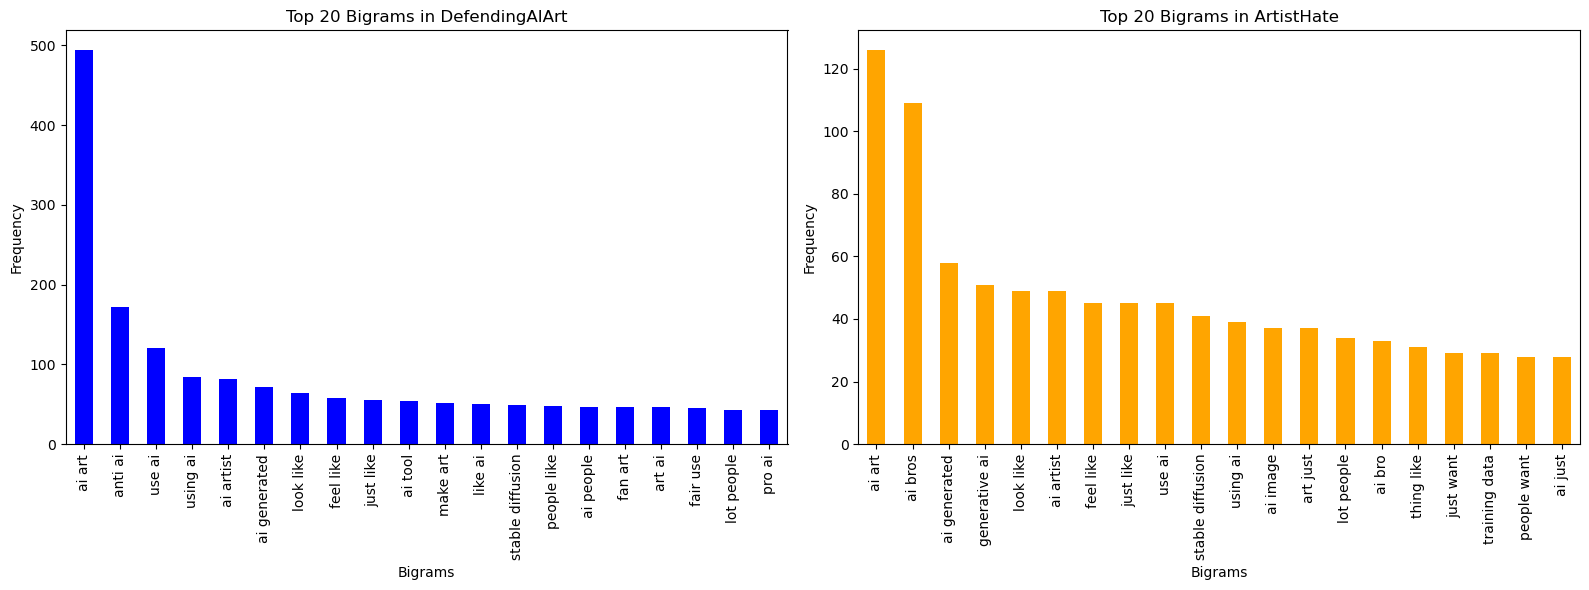

In [22]:
# Plotting for Bigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Bigrams in DefendingAIArt
top_bigrams_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 20 Bigrams in DefendingAIArt')
axes[0].set_xlabel('Bigrams')
axes[0].set_ylabel('Frequency')

# Plot for Bigrams in ArtistHate
top_bigrams_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 20 Bigrams in ArtistHate')
axes[1].set_xlabel('Bigrams')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

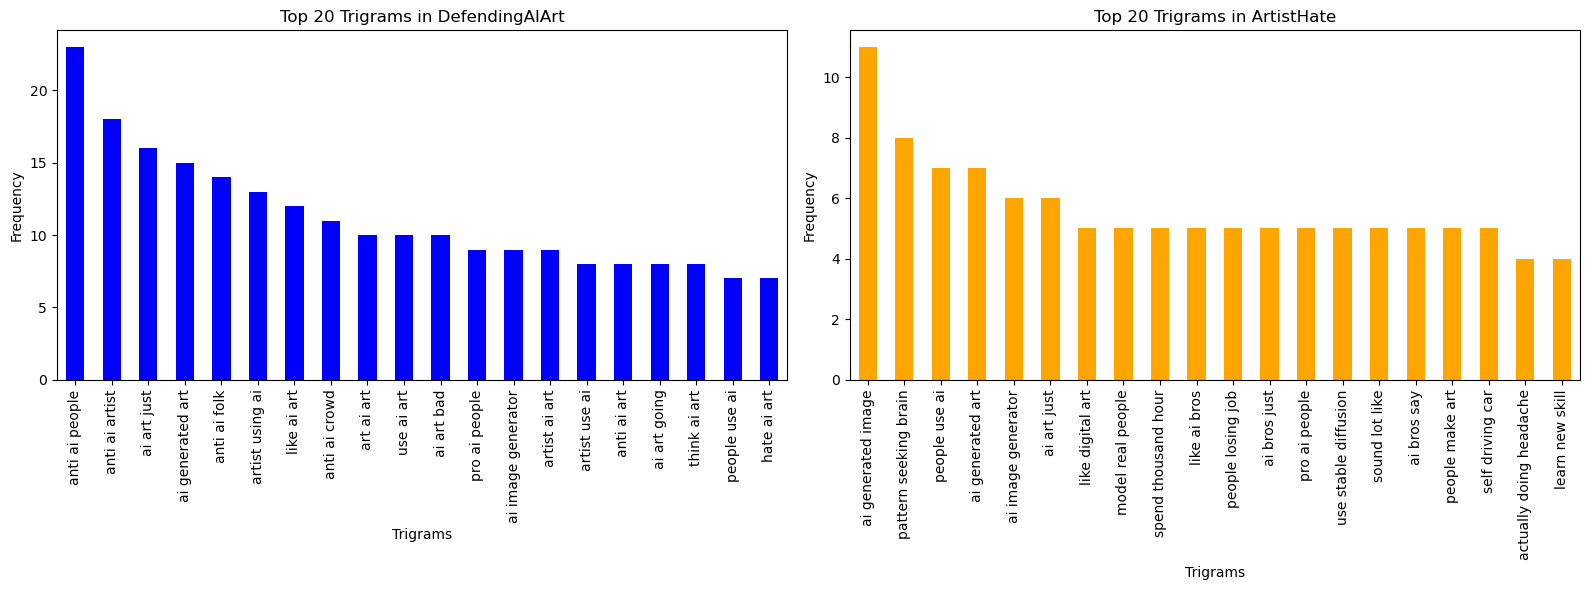

In [23]:
# Plotting for Trigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Trigrams in DefendingAIArt
top_trigrams_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 20 Trigrams in DefendingAIArt')
axes[0].set_xlabel('Trigrams')
axes[0].set_ylabel('Frequency')

# Plot for Trigrams in ArtistHate
top_trigrams_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 20 Trigrams in ArtistHate')
axes[1].set_xlabel('Trigrams')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### 03.03. Evaluation of most common words across both Subreddits
Top words by frequency counts on both camps did not differ very much, suggesting that either camp may simply be discussing different perspectives on the same AI-specific issues, e.g. **AI's ability to generate what is 'real' art or not** (with terms such as _'look like'/'feel like'/'just like'_) and **text-to-image capabilities** (e.g. _'Stable Diffusion'_). There is also some indication of concern about the use of **_'training data'_ for AI algorithms** in **r\ArtistHate**

## 04. Sentiment Analysis

In [24]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the 'body' column
reddit['sentiment_scores'] = reddit['body'].apply(lambda x: sent.polarity_scores(x))

# Expand the sentiment scores into separate columns
sentiment_df = reddit['sentiment_scores'].apply(pd.Series)

# Concatenate the sentiment scores DataFrame with the original DataFrame
reddit = pd.concat([reddit, sentiment_df], axis=1)

# Display the updated DataFrame
reddit.head()

,subr-def_ai,is_op,author,post_id,body,upvotes,num_comments,body_length,status_word_count,sentiment_scores,neg,neu,pos,compound
1,1,0,Zinthaniel,j2plqsw,"there's no rule in this sub requiring you to hide the tweet handle. So its kind of idiotic to do so, especially when the tweet is glorifying killing people who use AI.",30,1,167,33,"{'neg': 0.286, 'neu': 0.634, 'pos': 0.08, 'compound': -0.8313}",0.286,0.634,0.080,-0.8313
3,1,0,chillaxinbball,j2rbhzy,Unfortunately there are a few idiots on Twitter that are being rude which is giving the antiai crowd a huge confirmation bias boner. The Anti ai crowd has a hard time separating individuals from the group and seeing that the *majority* of the hateful comments comes from them.,12,0,276,48,"{'neg': 0.247, 'neu': 0.668, 'pos': 0.085, 'compound': -0.7906}",0.247,0.668,0.085,-0.7906
4,1,0,Trippy-Worlds,j2oyyyb,Why is the username crossed out? They need to be reported on Twitter and probably to the FBI. \n\nWould really like to see who all those likes are as well. Please tell us the Twitter ID. Suggesting violence is not permissible!,23,1,224,41,"{'neg': 0.081, 'neu': 0.714, 'pos': 0.204, 'compound': 0.6352}",0.081,0.714,0.204,0.6352
6,1,0,SoundProofHead,j3gby7r,"I don't expect nuance from a guy, on Twitter, with this kind of handle and this kind of profile pic. I'm not even right wing but I know this kind of people only see reality through a very specific political lens. They're walking cognitive biases and tend to go towards very black and white ideas.",5,0,296,58,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000
7,1,0,Affectionate-Echo289,j2srv6e,"Last month I would've said this guy is trolling.\n\nThen I joined a number of live chats discussing a variety of political and infrastrucutre issues surrounding the united states and canada.\n\nThe number of people convinced that the Jewish community has control of the weather has instilled in me the pure understanding that humanity is ultimately doomed.\n\nThere are thousands of people that literally, not as a joke, but literally believe that a religious group has a weather control machine that is used on the USA and Canada.\n\n&#x200B;\n\nWe are doomed. All anyone with a brain can do is really absorb what is happening and laugh.",10,0,628,108,"{'neg': 0.088, 'neu': 0.814, 'pos': 0.098, 'compound': -0.2249}",0.088,0.814,0.098,-0.2249


In [25]:
# Function to get subjectivity score using TextBlob
def get_subjectivity_score(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

# Apply subjectivity analysis to the 'body' column
reddit['subjectivity_score'] = reddit['body'].apply(get_subjectivity_score)

# Display the updated DataFrame
reddit.head()

,subr-def_ai,is_op,author,post_id,body,upvotes,num_comments,body_length,status_word_count,sentiment_scores,neg,neu,pos,compound,subjectivity_score
1,1,0,Zinthaniel,j2plqsw,"there's no rule in this sub requiring you to hide the tweet handle. So its kind of idiotic to do so, especially when the tweet is glorifying killing people who use AI.",30,1,167,33,"{'neg': 0.286, 'neu': 0.634, 'pos': 0.08, 'compound': -0.8313}",0.286,0.634,0.080,-0.8313,0.911111
3,1,0,chillaxinbball,j2rbhzy,Unfortunately there are a few idiots on Twitter that are being rude which is giving the antiai crowd a huge confirmation bias boner. The Anti ai crowd has a hard time separating individuals from the group and seeing that the *majority* of the hateful comments comes from them.,12,0,276,48,"{'neg': 0.247, 'neu': 0.668, 'pos': 0.085, 'compound': -0.7906}",0.247,0.668,0.085,-0.7906,0.656944
4,1,0,Trippy-Worlds,j2oyyyb,Why is the username crossed out? They need to be reported on Twitter and probably to the FBI. \n\nWould really like to see who all those likes are as well. Please tell us the Twitter ID. Suggesting violence is not permissible!,23,1,224,41,"{'neg': 0.081, 'neu': 0.714, 'pos': 0.204, 'compound': 0.6352}",0.081,0.714,0.204,0.6352,0.200000
6,1,0,SoundProofHead,j3gby7r,"I don't expect nuance from a guy, on Twitter, with this kind of handle and this kind of profile pic. I'm not even right wing but I know this kind of people only see reality through a very specific political lens. They're walking cognitive biases and tend to go towards very black and white ideas.",5,0,296,58,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,0.562394
7,1,0,Affectionate-Echo289,j2srv6e,"Last month I would've said this guy is trolling.\n\nThen I joined a number of live chats discussing a variety of political and infrastrucutre issues surrounding the united states and canada.\n\nThe number of people convinced that the Jewish community has control of the weather has instilled in me the pure understanding that humanity is ultimately doomed.\n\nThere are thousands of people that literally, not as a joke, but literally believe that a religious group has a weather control machine that is used on the USA and Canada.\n\n&#x200B;\n\nWe are doomed. All anyone with a brain can do is really absorb what is happening and laugh.",10,0,628,108,"{'neg': 0.088, 'neu': 0.814, 'pos': 0.098, 'compound': -0.2249}",0.088,0.814,0.098,-0.2249,0.301852


In [26]:
# Group by 'subr-def_ai' and calculate average scores
average_scores = reddit.groupby('subr-def_ai').agg({
    'neg': 'mean',
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean',
    'subjectivity_score': 'mean'
}).reset_index()

# Add labels for better readability
average_scores['subreddit'] = average_scores['subr-def_ai'].map({0: 'ArtistHate', 1: 'DefendingAIArt'})

# Reorder columns for better display
average_scores = average_scores[['subreddit', 'neg', 'neu', 'pos', 'compound', 'subjectivity_score']]

# Display the average scores
print(average_scores)

        subreddit       neg       neu       pos  compound  subjectivity_score
0      ArtistHate  0.092197  0.778060  0.129414  0.112899            0.463279
1  DefendingAIArt  0.096265  0.793212  0.110517  0.072731            0.491608


In [27]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6024 entries, 1 to 7439
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subr-def_ai         6024 non-null   int64  
 1   is_op               6024 non-null   int64  
 2   author              6024 non-null   object 
 3   post_id             6024 non-null   object 
 4   body                6024 non-null   object 
 5   upvotes             6024 non-null   int64  
 6   num_comments        6024 non-null   int64  
 7   body_length         6024 non-null   int64  
 8   status_word_count   6024 non-null   int64  
 9   sentiment_scores    6024 non-null   object 
 10  neg                 6024 non-null   float64
 11  neu                 6024 non-null   float64
 12  pos                 6024 non-null   float64
 13  compound            6024 non-null   float64
 14  subjectivity_score  6024 non-null   float64
dtypes: float64(5), int64(6), object(4)
memory usage: 753.0+ KB


### 04.01 Evaluation of Sentiment Analysis and Subjectivity Scores
For both subreddits, sentiments and subjectivity scores reflect slightly positive sentiments _(compound scores over 0.05)_, and on average a balance between subjective opinions and objective discussions _(subjectivity scores around 0.5)_. This is encouraging as it suggests the current discourse is not strongly polarising or emotional; however the overall positive sentiment inferred has its shortcomings as humour or sarcasm may not be picked up by the current algorithm.

### 05. Processed reddit dataframe is exported to .csv format for modeling

In [28]:
# Import library:
import os  # to work with files/directories

# Define the output folder path:
output_folder_path = '../project_3/output'

# Check if the output folder exists, and create it if not:
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Save CSV file within the 'output' folder:
reddit.to_csv(os.path.join(output_folder_path, 'reddit_for_model.csv'))